## Inicjalizacja


In [3]:
from laptoppriceworkflow.data import get_json_data 
from laptoppriceworkflow.functions import clean_col_meta
from laptoppriceworkflow.functions import simplify_gwarancja
from laptoppriceworkflow.functions import simplify_komunikacja

import pandas as pd

import numpy as np

import seaborn as sns 

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [4]:
df = get_json_data()

# Partycjonowanie
Preprocessing przygotowania modelu bedzie przeprowadzany tylko na czesci treningowej 
Pozniej przepuszcze przez niego czesc testowa, ktora swtorzylem oraz dodtkowy plik bez zmiennej celu

In [5]:
msk = np.random.rand(len(df)) < 0.75
train = df[msk]
test = df[~msk]

In [7]:
train.head(4)

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9"""
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9"""
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9"""
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9"""


In [5]:
train["rodzaj karty graficznej"].fillna('0').map(lambda x: x.split("grafika")[-1].strip())

70       zintegrowana
1489       dedykowana
1359     zintegrowana
10567               0
3203     zintegrowana
             ...     
7596       dedykowana
6406       dedykowana
10541    zintegrowana
8053       dedykowana
8727       dedykowana
Name: rodzaj karty graficznej, Length: 5903, dtype: object

# Wstępna Analiza

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5903 entries, 70 to 8727
Data columns (total 17 columns):
buynow_price                         5903 non-null float64
rodzaj karty graficznej              5526 non-null object
komunikacja                          5320 non-null object
rozdzielczość (piksele)              5437 non-null object
liczba rdzeni procesora              5903 non-null object
wielkość pamięci ram                 5560 non-null object
system operacyjny                    5412 non-null object
typ dysku twardego                   5571 non-null object
sterowanie                           5383 non-null object
multimedia                           5362 non-null object
typ pamięci ram                      5246 non-null object
taktowanie bazowe procesora (ghz)    5191 non-null float64
seria procesora                      5500 non-null object
stan                                 5903 non-null object
pojemność dysku (gb)                 5532 non-null float64
gwarancja          

In [7]:
train.isnull().sum()/train.shape[0]

buynow_price                         0.000000
rodzaj karty graficznej              0.063866
komunikacja                          0.098763
rozdzielczość (piksele)              0.078943
liczba rdzeni procesora              0.000000
wielkość pamięci ram                 0.058106
system operacyjny                    0.083178
typ dysku twardego                   0.056243
sterowanie                           0.088091
multimedia                           0.091648
typ pamięci ram                      0.111299
taktowanie bazowe procesora (ghz)    0.120617
seria procesora                      0.068270
stan                                 0.000000
pojemność dysku (gb)                 0.062849
gwarancja                            0.000000
wielkość matrycy                     0.045401
dtype: float64

In [28]:
# Funkcja sprawdzajaca liczbe kategorii w kolumnie

for col_name in train.columns:
    if train[col_name].dtypes == 'object':
        unique_cat = len(train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories" .format(
            col_name =col_name, unique_cat = unique_cat))

Feature 'rodzaj karty graficznej' has 3 unique categories


TypeError: unhashable type: 'list'

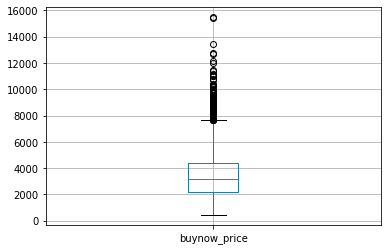

In [8]:
train.boxplot("buynow_price")

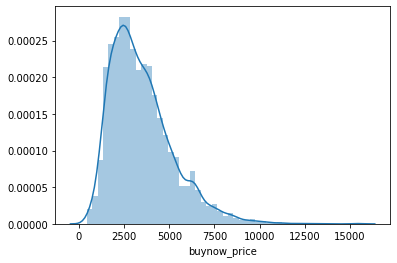

In [9]:
sns.distplot(train["buynow_price"])
plt.show()

# Budowa Preprocesingu

In [8]:
train_num = train[['taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)', 'wielkość pamięci ram']]

In [9]:
train[['taktowanie bazowe procesora (ghz)', 'pojemność dysku (gb)', 'wielkość pamięci ram']].head(10)

,taktowanie bazowe procesora (ghz),pojemność dysku (gb),wielkość pamięci ram
70,1.9,500.0,8 gb
1359,2.0,480.0,8 gb
3203,1.5,128.0,8 gb
7831,1.6,120.0,4 gb
4586,1.7,256.0,8 gb
7524,2.6,1000.0,8 gb
8158,2.6,480.0,8 gb
1864,2.8,1256.0,16 gb
5561,NaN,NaN,None
4717,NaN,1000.0,16 gb


imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_num)
imputer.statistics_

X = imputer.transform(df_num)
df_num_imp = pd.DataFrame(X, columns=df_num.columns)


encoder = LabelEncoder()
#df_cat = df[["rodzaj karty graficznej", "komunikacja","rozdzielczość (piksele)"]]
df_cat = df["liczba rdzeni procesora"]
df_cat_encoded = encoder.fit_transform(df_cat)
df_cat_encoded

Lepsze gdy w kolumnie masz bardzo dużo kategorii i powstaje macierz rzadka (sparse matrix)
W innym przypadku lepiej LabelBinarizer() :)

In [23]:
class FeatureEng(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #imm = joblib.load(PATH_TO_IMM)
        #metadata_dense = reduce_mem_usage(pd.read_csv(METADATA_DENSE).fillna(0))
        #X["country"] = X["city"].map(lambda x: x.split(",")[-1].strip())
        X["rodzaj karty graficznej"].fillna("", inplace=True)
        X["komunikacja"].fillna("", inplace=True)
        X["rozdzielczość (piksele)"].fillna("", inplace=True)
        
        X['liczba_rdzeni_proc_trans'] = ['2' if x == '2' else '' for x in X.loc[:,"liczba rdzeni procesora"]]
        
        X.drop('liczba rdzeni procesora', axis = 1)
        
        X["wielkość pamięci ram"].fillna('0', inplace=True)
        X["wielkosc_pamieci_ram_trans"] = [0 if "mb" in x else int(x.strip('gb')) for x in X.loc[:, "wielkość pamięci ram"]]
        X.drop("wielkość pamięci ram", axis = 1)
        
        X["system operacyjny"].fillna('', inplace=True)
        X["typ dysku twardego"].fillna('', inplace=True)
        
        return X

In [11]:
vectorizer = FeatureEng()
vectorizer.fit_transform(train)
#ddd  = FeatureEng.fit_transform(train)

C:\Users\marcin\Miniconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,buynow_price,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy,liczba_rdzeni_proc_trans,wielkosc_pamieci_ram_trans
70,1599.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,nowy,500.0,sprzedawcy,"13"" - 13.9""",2,8
1359,2849.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,480.0,producenta,"15"" - 15.9""",2,8
3203,1302.91,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.5,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9""",2,8
7831,1699.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.6,intel pentium quad-core,nowy,120.0,producenta,"15"" - 15.9""",,4
4586,1769.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.7,intel core i3,nowy,256.0,sprzedawcy,"15"" - 15.9""",2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10541,1329.00,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.6,intel celeron dual-core,nowy,128.0,sprzedawcy,"15"" - 15.9""",2,4
8281,979.00,,,,2,0,,,None,None,None,NaN,None,nowy,32.0,producenta,None,2,0
8053,2565.00,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.3,intel core i5,nowy,128.0,sprzedawcy,"15"" - 15.9""",2,4
8727,4079.00,grafika dedykowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",1920 x 1080,4,16 gb,[windows 10 home],ssd + hdd,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,1128.0,producenta,"15"" - 15.9""",,16


In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

In [13]:
mlb = MultiLabelBinarizer()
expandedLabelData = mlb.fit_transform(train["komunikacja"][0:4])
labelClasses = mlb.classes_
#labelClasses

# Create a pandas.DataFrame from our output
expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)

In [14]:
expandedLabels

,bluetooth,lan 10/100 mbps,lan 10/100/1000 mbps,wi-fi
0,1,0,1,1
1,1,0,1,1
2,1,1,0,0
3,1,1,0,1


In [15]:
train["komunikacja"].apply(pd.Series).stack().unique().tolist()

['wi-fi',
 'bluetooth',
 'lan 10/100/1000 mbps',
 'lan 10/100 mbps',
 '',
 'nfc (near field communication)',
 'intel wireless display (widi)',
 'modem 3g (wwan)',
 'gps',
 'wi-fi 802.11 b/g/n/ac',
 'modem 4g (lte)',
 'wi-fi 802.11 a/b/g/n/ac',
 'wi-fi 802.11 b/g/n',
 'wi-fi 802.11 a/b/g/n']

In [ ]:
count_komunikacja_item = {}
    #for i in train["komunikacja"].apply(pd.Series).stack().unique().tolist():
    #    temp_ = (df["komunikacja_t"].str.contains(i, regex=False)*1).sum()
    #    count_komunikacja_item[i]= temp_
for i in train["komunikacja"].apply(pd.Series).stack().unique().tolist():
    df[i] = (df["komunikacja_t"].str.contains(i, regex=False)*1).fillna(0)   

In [32]:
class DataFrameImputer(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
        
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else np.NaN for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X[self.attribute_names].fillna(self.fill).values

In [34]:
#rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

#buynow_price_ix, taktowanie_bazowe_procesora_ghz_ix, pojemność_dysku_gb_ix = 0, 1, 2
wielkosc_pamieci_ram_ix = 2

class CombinedAttributesAdder_num(BaseEstimator, TransformerMixin):
    
    def __init__(self, wielkosc_pamiec_ram = True): # żadnych zmiennych *args ani **kargs
        self._wielkosc_pamiec_ram = wielkosc_pamiec_ram
    
    def fit(self, X, y=None):
        return self # nie robi nic innego
    
    def transform(self, X, y=None):
        if self._wielkosc_pamiec_ram:
            
            #create new column
            wielkosc_pamieci_ram_trans = [0 if "mb" in x else int(x.strip('gb')) for x in X[:, wielkosc_pamieci_ram_ix]]
            
            #drop redundant column
            X = np.delete(X, np.s_[wielkosc_pamieci_ram_ix], 1)
            
            
            return np.c_[wielkosc_pamieci_ram_trans, X]
        else:
            return X

In [171]:
attr_adder = CombinedAttributesAdder(add_price_per_gb=True)
df_extra_attribs = attr_adder.transform(df.values)

In [62]:
gwarancja_ix = 0
rozdzielczosc_ix = 3
liczba_rdzeni_proc_ix = 4
seria_procesora_ix = 5

class CombinedAttributesAdder_cat(BaseEstimator, TransformerMixin):
                 
    def __init__(self, gwarancja_trans = True):
        self._gwarancja_trans = gwarancja_trans
        self._trans_gwrancja = trans_gwarancja
        self._trans_gwrancja = trans_gwarancja
        self._trans_gwrancja = trans_gwarancja
    
    def fit(self, X, y = None):
        return self # nie robi nic innego
    
    def transform(self, X, y = None):
        if self._gwarancja_trans:
            gwarancja_trans = ['producenta' if x == 'producenta' else 'other' for x in X[:, gwarancja_ix]]
            X = np.delete(X, np.s_[gwarancja_ix, rozdzielczosc_ix, liczba_rdzeni_proc_ix, seria_procesora_ix], 1)
            
            rozdzielczosc_trans = ['1920 x 1080' if x == '1920 x 1080' else '1366 x 768' if x == '1366 x 768' else 'other' for x in X[:, rozdzielczosc_ix]]
            X = np.delete(X, np.s_[gwarancja_ix, rozdzielczosc_ix, liczba_rdzeni_proc_ix, seria_procesora_ix], 1)
            
            liczba_rdzeni_proc_trans = ['2' if x == '2' else 'other' for x in X[:, liczba_rdzeni_proc_ix]]
            X = np.delete(X, np.s_[gwarancja_ix, rozdzielczosc_ix, liczba_rdzeni_proc_ix, seria_procesora_ix], 1)
            
            seria_procesora_trans = ['intel core i7' if x == 'intel core i7 ' else 'intel core i5' if x == 'intel core i5' else 'intel core i3' if x == 'intel core i3' else 'other' for x in X[:,seria_procesora_ix]]
            X = np.delete(X, np.s_[gwarancja_ix, rozdzielczosc_ix, liczba_rdzeni_proc_ix, seria_procesora_ix], 1)
                               
         #   return np.c_[np.asarray(gwarancja_trans).reshape(-1,1), rozdzielczosc_trans, liczba_rdzeni_proc_trans, seria_procesora_trans, X]
        #else:
            return X

In [16]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [20]:
class selector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y):
        return self
    
    def transofrm(self, X):
        return X[self.column]

In [44]:
selector(train['gwarancja'])

selector(column=70       sprzedawcy
407      producenta
1359     producenta
10567    producenta
7524     producenta
            ...    
11695    sprzedawcy
8281     producenta
8053     sprzedawcy
8727     producenta
5978     producenta
Name: gwarancja, Length: 5974, dtype: object)

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [35]:
cat_attribs = list(["gwarancja", "typ dysku twardego","rodzaj karty graficznej", "rozdzielczość (piksele)", "liczba rdzeni procesora", 'seria procesora'])
num_attribs = list(train_num)
numerical_features = list(["wielkość pamięci ram"])

#dd = list(['pojemność dysku (gb)', 'gwarancja'])

cat_pipeline = make_pipeline(
        FeatureEng(),
            ColumnTransformer(
            [
                (
                    "numerical",
                    make_pipeline(PandasToNpArray(), SimpleImputer(strategy="constant", fill_value=-9999)),
                    numerical_features,
                ),
            ]
        )
    
    #('selector', DataFrameSelector(cat_attribs)),
    #('imputerr', SimpleImputer(missing_values=None, strategy="most_frequent")),
    #('attribs_adder_cat',CombinedAttributesAdder_cat()),
    #('cat_encoder', OneHotEncoder(sparse=False)),
    )

num_pipeline = Pipeline([
    ('Imputer_cat', DataFrameImputer(num_attribs)),
    #('selector', DataFrameSelector(num_attribs)),
    #('imputer', SimpleImputer(strategy="constant", fill_value=None)),
    ('attribs_adder_num', CombinedAttributesAdder_num()),
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler()),
    ])



In [36]:
ttt = cat_pipeline.fit_transform(train)

C:\Users\marcin\Miniconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

ValueError: could not convert string to float: '8 gb'

In [28]:
def to_records(df):
    return df.to_dict(orient='records')

In [32]:
aa = train.copy()
ab = to_records(aa)
ab

[{'buynow_price': 1599.0,
  'rodzaj karty graficznej': 'grafika zintegrowana',
  'komunikacja': ['wi-fi', 'bluetooth', 'lan 10/100/1000 mbps'],
  'rozdzielczość (piksele)': '1366 x 768',
  'liczba rdzeni procesora': '2',
  'wielkość pamięci ram': '8 gb',
  'system operacyjny': ['windows 10 home'],
  'typ dysku twardego': 'hdd',
  'sterowanie': ['klawiatura', 'touchpad'],
  'multimedia': ['czytnik kart pamięci', 'kamera', 'głośniki', 'mikrofon'],
  'typ pamięci ram': 'ddr3',
  'taktowanie bazowe procesora (ghz)': 1.9,
  'seria procesora': 'intel core i3',
  'stan': 'nowy',
  'pojemność dysku (gb)': 500.0,
  'gwarancja': 'sprzedawcy',
  'wielkość matrycy ': '13" - 13.9"',
  'liczba_rdzeni_proc_trans': '2',
  'wielkosc_pamieci_ram_trans': 8},
 {'buynow_price': 2999.0,
  'rodzaj karty graficznej': 'grafika zintegrowana',
  'komunikacja': ['wi-fi', 'bluetooth', 'lan 10/100/1000 mbps'],
  'rozdzielczość (piksele)': '1366 x 768',
  'liczba rdzeni procesora': '2',
  'wielkość pamięci ram': '16

In [45]:
one_hot_encoder = make_pipeline(FunctionTransformer(to_records, validate=False), DictVectorizer())

In [46]:
pipeline = make_pipeline(
    FeatureEng(),
    make_union(
        #make_pipeline(selector("rodzaj karty graficznej"), CountVectorizer(min_df=10, dtype=np.float64)),
        #make_pipeline(Selector("brand_name"), CountVectorizer(min_df=10, dtype=np.float64)),
        #make_pipeline(Selector("item_description"), CountVectorizer(min_df=10, dtype=np.float64)),
        make_pipeline(selector(["rodzaj karty graficznej"]), one_hot_encoder)
    )
    #,
    #ridge_model
)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'selector(column=['rodzaj karty graficznej'])' (type <class '__main__.selector'>) doesn't

In [27]:
class PandasToNpArray(BaseEstimator, TransformerMixin):
    def fit(self, X, *arg):
        return self

    def transform(self, X):
        return X.values.astype(np.float)

In [523]:
numerical_features= list(["taktowanie bazowe procesora (ghz)"])

In [524]:
dupa = make_pipeline(
        FeatureEng(),
        ColumnTransformer(
            [
                (
                    "numerical",
                    make_pipeline(PandasToNpArray(), SimpleImputer(strategy="constant", fill_value=-9999)),
                    numerical_features,
                ),
            ]
        )
)

In [525]:
#tt = num_pipeline.fit_transform(train[0:2])
#tt = num_pipeline.fit_transform(train[['pojemność dysku (gb)', 'gwarancja']])
#tt = num_pipeline.fit_transform(train)


#.fit_transform
ttt = dupa.fit_transform(train)

C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\marcin\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [526]:
ttt

array([[ 1.900e+00],
       [ 2.100e+00],
       [ 2.000e+00],
       ...,
       [-9.999e+03],
       [ 2.300e+00],
       [ 2.400e+00]])

In [316]:
full_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline", cat_pipeline),
    ("num_pipeline", num_pipeline),
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [317]:
housing_prepared = full_pipeline.fit_transform(train)
housing_prepared[0:6]

array([[ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        , -0.2607585 , -1.18450975, -0.33657005],
       [ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.99003772, -0.64048825, -0.38094826],
       [ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        , -0.2607585 , -0.912499  , -0.38094826],
       [ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  

In [55]:
#pd.DataFrame(df_extra_attribs, columns=df_num.columns)
#train_labels = pd.DataFrame(housing_prepared, columns = df_num.columns.append(pd.Index(['price_per_ghz','4242'])))


,buynow_price,taktowanie bazowe procesora (ghz),pojemność dysku (gb),price_per_ghz,4242
0,1599.0,1.9,500.0,0.001188,0.312695
1,2999.0,2.0,480.0,0.000667,0.160053
2,2999.0,2.1,480.0,0.000700,0.160053
3,2849.0,2.0,480.0,0.000702,0.168480
4,2319.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
7848,1329.0,1.6,128.0,0.001204,0.096313
7849,979.0,NaN,32.0,NaN,0.032686
7850,2565.0,2.3,128.0,0.000897,0.049903
7851,4079.0,2.5,1128.0,0.000613,0.276538


In [318]:
train_labels = train['buynow_price'].copy()
test_labels = test['buynow_price'].copy()


In [319]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [320]:
some_data = test
some_labels = test_labels

some_data_prepared = full_pipeline.transform(some_data)
print("Prognozy:", lin_reg.predict(some_data_prepared))
print("Etykiety:", list(some_labels))

Prognozy: [3174. 3468. 3826. ... 4310. 4454. 4850.]
Etykiety: [2999.0, 2677.0, 4299.0, 6738.0, 1749.0, 3099.0, 4419.0, 1599.0, 3499.0, 4649.0, 3769.0, 1346.0, 4949.0, 2619.0, 3299.0, 3069.0, 2289.0, 4499.0, 5309.0, 1419.0, 1479.0, 4209.0, 3849.0, 5519.0, 3099.0, 4989.0, 4065.24, 3659.0, 1599.0, 3999.0, 3418.0, 2349.0, 3799.0, 3399.0, 2699.0, 3368.0, 2399.0, 3099.0, 3499.0, 2799.0, 1449.0, 5820.0, 5799.0, 3749.0, 9315.0, 3599.0, 2299.0, 5299.0, 2461.0, 1404.0, 1779.0, 2083.67, 3498.0, 2749.0, 1489.0, 2299.0, 4032.25, 2529.0, 1799.0, 2919.0, 2299.0, 1899.0, 3199.0, 1179.9, 1742.0, 4333.0, 2729.0, 2099.0, 6304.0, 3799.0, 1099.0, 4399.0, 2259.0, 1599.0, 6858.9, 2199.0, 2099.0, 4529.0, 1319.0, 2429.0, 2570.0, 4879.0, 4009.0, 2099.0, 4787.53, 2817.0, 3849.0, 5699.0, 1649.0, 4649.0, 4927.0, 2349.0, 4399.0, 8186.0, 3999.0, 5771.0, 1442.0, 2199.01, 4373.0, 11072.71, 2599.01, 2449.0, 3049.0, 1249.0, 2449.0, 2239.0, 2099.0, 5732.0, 1949.0, 1269.0, 4989.0, 1709.0, 1589.0, 4454.56, 8299.0, 2289.0, 

In [322]:
price_predictions = lin_reg.predict(some_data_prepared)
lin_mse = mean_squared_error(test_labels, price_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1119.175415472309

In [5]:
train = clean_col_meta(train)

In [11]:
df["lan 10/100 mbps"] = (df["komunikacja"].str.contains('lan 10/100 mbps', regex=False)*1).sum()

In [12]:
df["lan 10/100/1000 mbps"] = (df["komunikacja"].str.contains('lan 10/100/1000 mbps', regex=False)*1).sum()

In [13]:
(df["komunikacja"].str.contains('nfc (near field communication)', regex=False)*1).sum()

1454

In [14]:
(df["komunikacja"].str.contains('modem 3g (wwan)', regex=False)*1).sum()

1009

In [15]:
(df["komunikacja"].str.contains('gps', regex=False)*1).sum()

269

In [16]:
(df["komunikacja"].str.contains('intel wireless display (widi)', regex=False)*1).sum()

1004

In [17]:
(df["komunikacja"].str.contains('modem 4g (lte)', regex=False)*1).sum()

267

In [18]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n', regex=False)*1).sum()

73

In [19]:
(df["komunikacja"].str.contains('wi-fi 802.11 b/g/n/ac', regex=False)*1).sum()

166

In [20]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n/ac', regex=False)*1).sum()

143

In [21]:
(df["komunikacja"].str.contains('wi-fi 802.11 a/b/g/n', regex=False)*1).sum()

17

In [22]:
df.shape

(7853, 20)

In [23]:
160/7853

0.020374379218133197

In [24]:
df.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
       'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'],
      dtype='object')

In [25]:
df.index

Int64Index([   70,  1489,   407,  1359, 10567,  3203,  7831,  4586,  7524,
            10973,
            ...
             6423,  7596, 11321, 11695,  6406, 10541,  8281,  8053,  8727,
             5978],
           dtype='int64', length=7853)

In [26]:
assert all(df.columns == ['buynow_price', 'rodzaj karty graficznej', 'komunikacja','rozdzielczość (piksele)', 'liczba rdzeni procesora',
        'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
        'sterowanie', 'multimedia', 'typ pamięci ram',
        'taktowanie bazowe procesora (ghz)', 'seria procesora',
        'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy ', 'bluetooth',
        'wi-fi', 'lan 10/100 mbps', 'lan 10/100/1000 mbps'])